In [62]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'resnet50_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
! unzip -o /content/drive/MyDrive/dataset_19.zip
# ! unzip -o /content/drive/MyDrive/Brain_MRI.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: dataset_19/glioma/Te-gl_012

# Load the data

In [65]:
# Data Directories
dir = "dataset_19/"
# validation_dir = "Testing"

# Data distribution

In [66]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
glioma        120
meningioma    120
notumor       120
dtype: int64

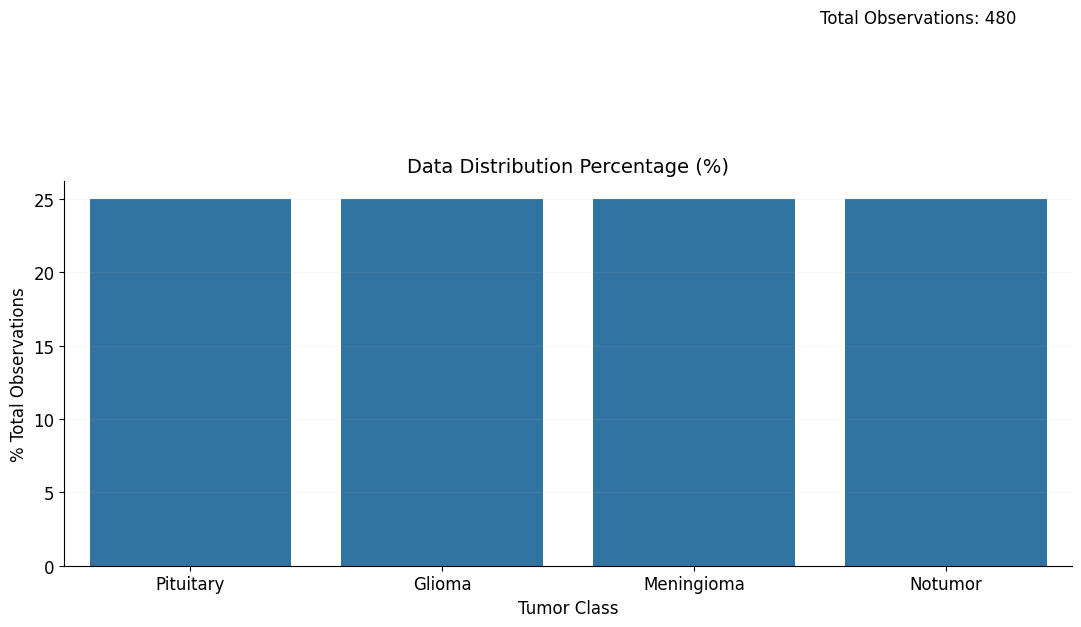

In [67]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data

In [68]:
# from tqdm import tqdm
# import cv2
# import imutils

# def crop_img(img):

# 	# Find extreme points on the image and crop the rectangular out

# 	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# 	gray = cv2.GaussianBlur(gray, (3, 3), 0)

# 	# threshold the image, then perform a series of erosions +
# 	# dilations to remove any small regions of noise
# 	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
# 	thresh = cv2.erode(thresh, None, iterations=2)
# 	thresh = cv2.dilate(thresh, None, iterations=2)

# 	# find contours in thresholded image, then grab the largest one
# 	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 	cnts = imutils.grab_contours(cnts)
# 	c = max(cnts, key=cv2.contourArea)

# 	# find the extreme points
# 	extLeft = tuple(c[c[:, :, 0].argmin()][0])
# 	extRight = tuple(c[c[:, :, 0].argmax()][0])
# 	extTop = tuple(c[c[:, :, 1].argmin()][0])
# 	extBot = tuple(c[c[:, :, 1].argmax()][0])
# 	ADD_PIXELS = 0
# 	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# 	return new_img

# def preprocess_images(directory):
#     for dir in os.listdir(directory):
#         path = os.path.join(directory, dir)
#         for img_name in os.listdir(path):
#             img_path = os.path.join(path, img_name)
#             img = cv2.imread(img_path)
#             cropped_img = crop_img(img)
#             cv2.imwrite(img_path, cropped_img)

# # Preprocess the images before generating data
# preprocess_images(dir)
# # preprocess_images(validation_dir)

# Split data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


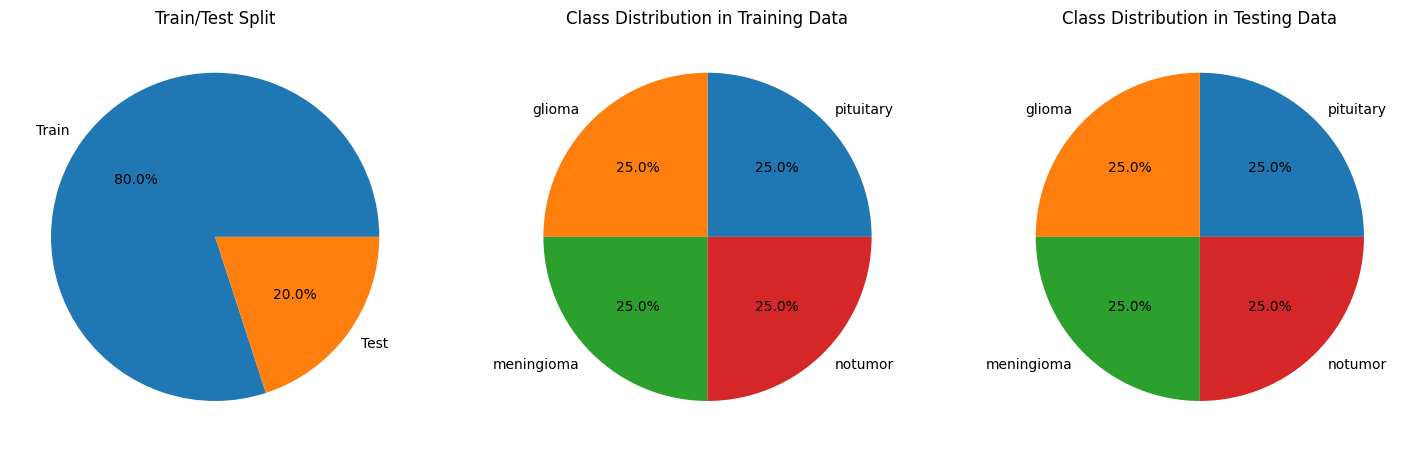

In [69]:
classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(512, 512),
    batch_size=16,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(512, 512),
    batch_size=16,
    seed=42,
    subset='validation')


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# Functions to train model

In [91]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras.applications import ResNet50
import matplotlib.pyplot as plt

# Define the model creation function
def create_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
      layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the model training function
def train_model(model, train_generator, test_generator, model_name):
    checkpoint = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    #early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2,verbose=1, mode='min', min_lr=0.0000000)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=50,
        callbacks=[checkpoint, reduce_lr]
    )

    model.save(model_name)
    return model, history

# Create/Load model

In [92]:
# Check if the model exists, else create and train it
if os.path.exists(model_file):
    model = load_model(model_file)
else:
    model = create_model((512, 512, 3), len(classes))

# Plot the model architecture
plot_model(model, to_file='resnet50_model.png', show_shapes=True, show_layer_names=True)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [93]:
model, history = train_model(model, train_generator, test_generator, model_file)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 0.7557 - accuracy: 0.7370
Epoch 1: val_loss improved from inf to 3.77081, saving model to resnet50_brain_mri.keras
24/24 [==============================] - 57s 1s/step - loss: 0.7557 - accuracy: 0.7370 - val_loss: 3.7708 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9089
Epoch 2: val_loss improved from 3.77081 to 3.58109, saving model to resnet50_brain_mri.keras
24/24 [==============================] - 24s 993ms/step - loss: 0.2470 - accuracy: 0.9089 - val_loss: 3.5811 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9531
Epoch 3: val_loss did not improve from 3.58109
24/24 [==============================] - 22s 916ms/step - loss: 0.1277 - accuracy: 0.9531 - val_loss: 4.4478 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 4/50
24/24 [===========================

# Testing the model

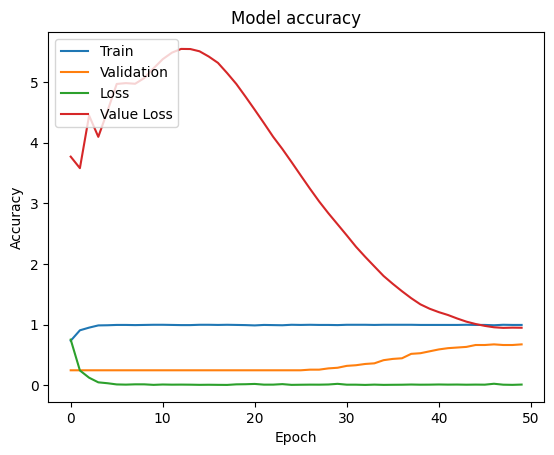

In [94]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

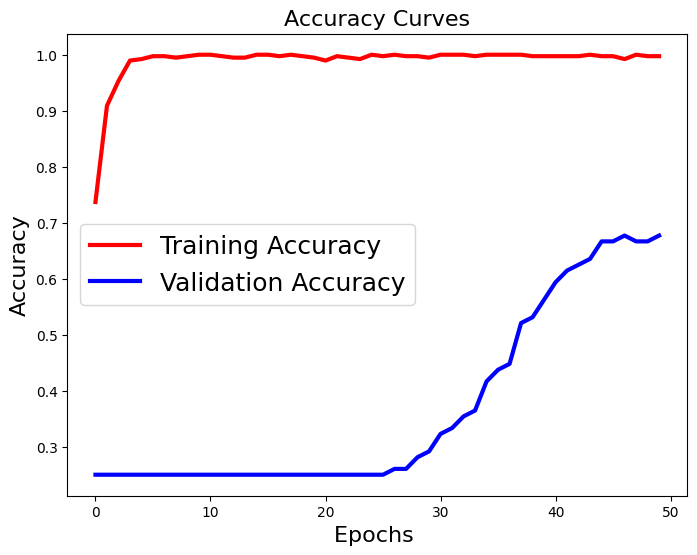

In [95]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

# Validate with external test data

6/6 [==============================] - 2s 274ms/step


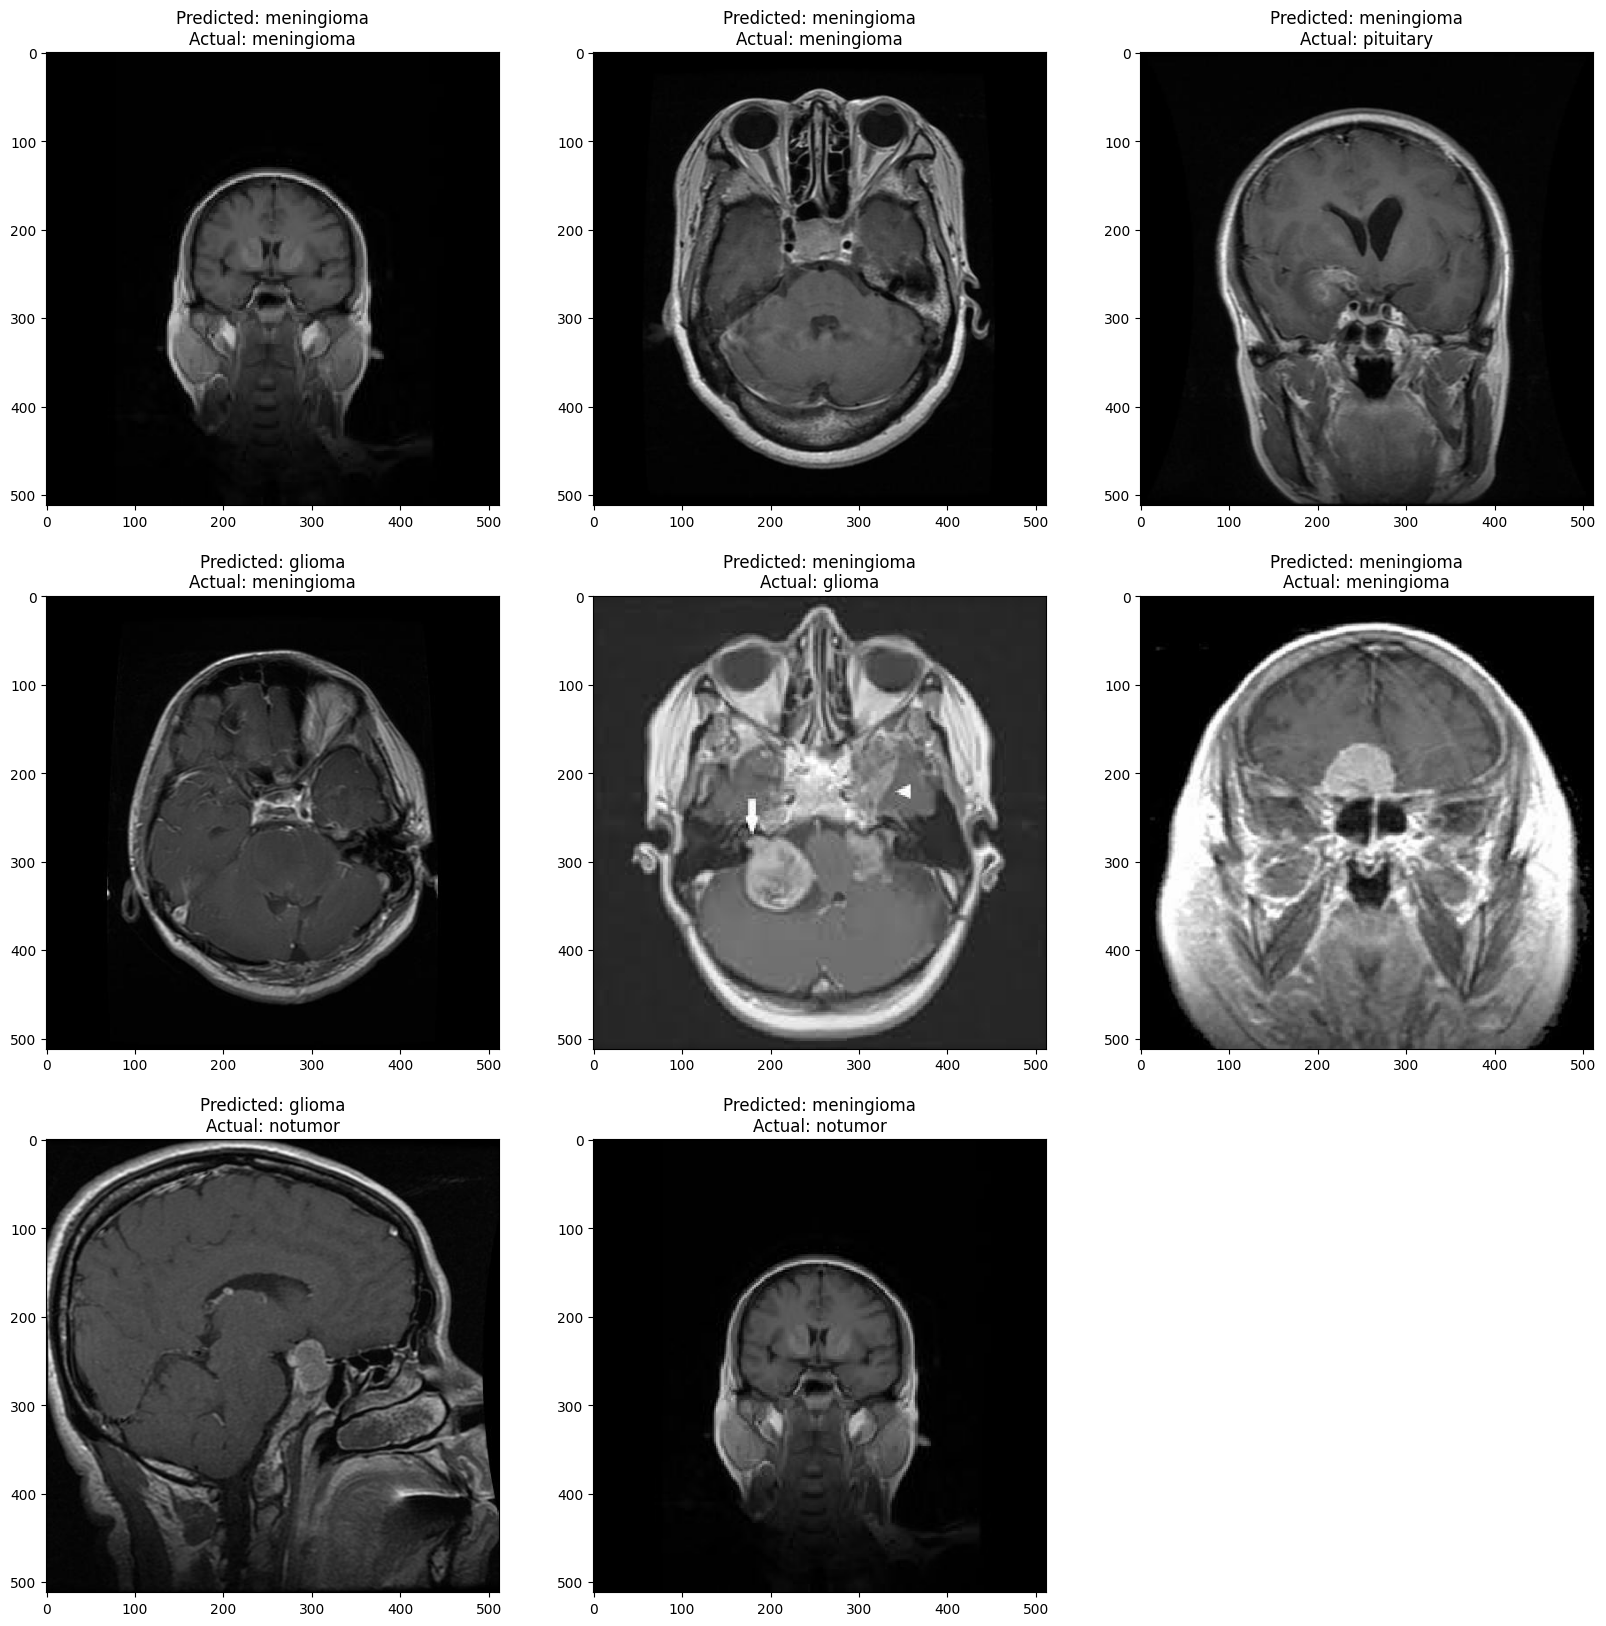

In [96]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)

# Predict the output
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break

# Model visualization(Evaluation)

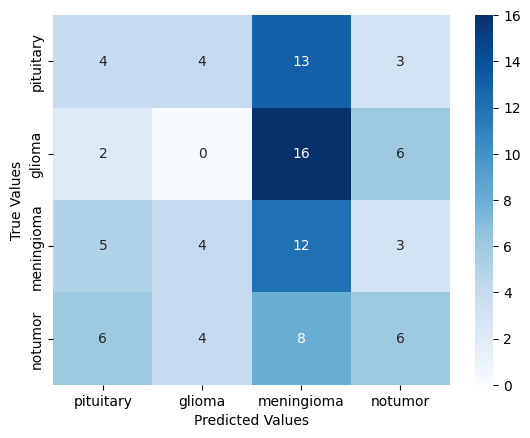

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');

In [98]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Usage:
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

DSC: 0.20240084005536726, Sensitivity: 0.22916666666666666, Specificity: 0.7430555555555556, Accuracy: 0.22916666666666666
